In [24]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
import nltk
import pandas as pd
nltk.download('punkt')
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [206]:
import os
rootdir = '/home/stephane/automatic-data-generation/automatic_data_generation/'
dataroot= rootdir + 'data/'
os.chdir(rootdir)

# Exploring the vocabulary

In [26]:
from models.embedding import Datasets
datasets = Datasets(train_path=dataroot+'snips/train.csv', valid_path=dataroot+'snips/validate.csv', emb_dim=100, tokenizer='nltk')
vocab = datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

In [27]:
i2w[:20]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 'a',
 'to',
 '_object_type_',
 'for',
 '_object_name_',
 'in',
 '_playlist_',
 'i',
 'at',
 '_timerange_',
 '_rating_value_',
 '_artist_',
 'play',
 '_music_item_',
 'of']

In [190]:
list(datasets.train)[0].labels

AttributeError: 'Example' object has no attribute 'labels'

In [39]:
def word2idx(sentences, w2i):

    idx = [[] for i in range(len(sentences))]

    for i, sent in enumerate(sentences):

        for token in sent:
            idx[i].append(w2i[token])

    return idx

# Karpathy CharRNN

### Temperature: 0.2

I want to book a reservation for a restaurant for a party of a party of 6 points

I want to book a reservation for a restaurant for a restaurant for a restaurant in Barken Marcha at a party of 6

I need a table for a restaurant for a party of a party of 6 points

### Temperature: 0.5
I need a table for a reservation for a restaurant in the area that serves find movement in the area at a party of a siming from now

I want to half album to Musaf Rock Story Barb playlist.

I want to give this current book The Very Satarora for the twenty-textbook.

### Temperature: 1.0
What will the weather be syar llind in Playlin Man.

Tell it i from the Shawnua Tf Hiss Morny Cimes

Hadon in a top-fight?

play the song from the fifties for ten in Mondital Maker

# Analyzing the runs

In [178]:
def anneal_fn(anneal_function, step, k, x, m):
    if anneal_function == 'logistic':
        return m*float(1/(1+np.exp(-k*(step-x))))
    elif anneal_function == 'linear':
        return m*min(1, step/x)
anneal_fn = np.vectorize(anneal_fn)

In [179]:
import torch
run = torch.load('run.pkl')

## Dynamics

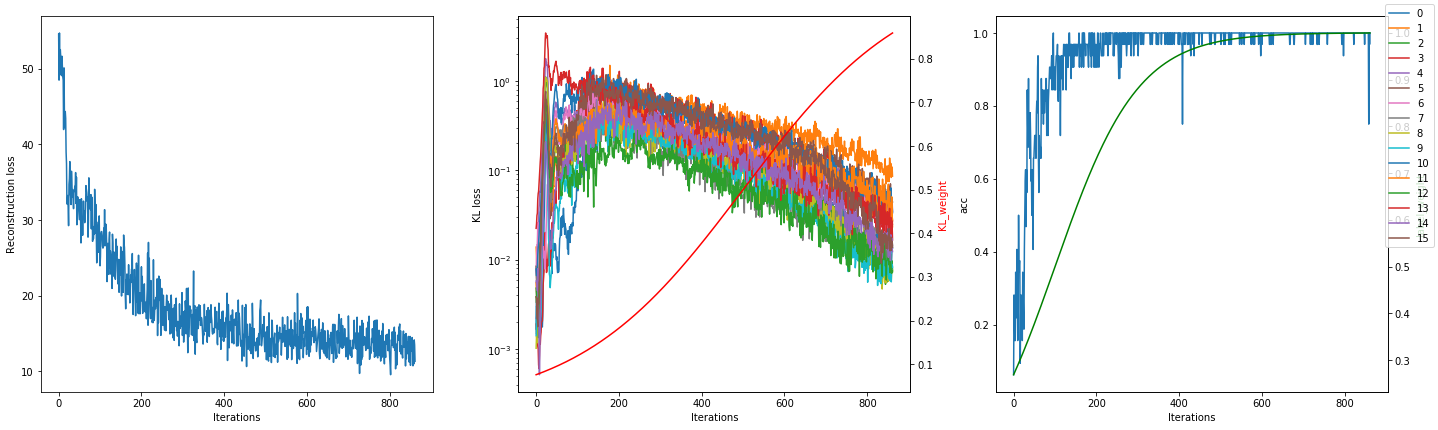

In [180]:
fig, axarr = plt.subplots(1,3, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['NLL_hist']
KL_hist  = run['KL_hist' ]
NMI_hist = run['NMI_hist']
acc_hist = run['acc_hist']
t = np.array(range(len(NLL_hist)))

KL_weight = anneal_fn(args.anneal_function, t, args.k1, args.x1, args.m1)
label_weight = anneal_fn(args.anneal_function, t, args.k2, args.x2, args.m2)

KL_hist = np.array(KL_hist)
axarr[0].plot(t, NLL_hist )
for i in range(args.latent_size):
    axarr[1].semilogy(t, KL_hist[:,i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')

fig.legend()
fig.tight_layout()
plt.show()

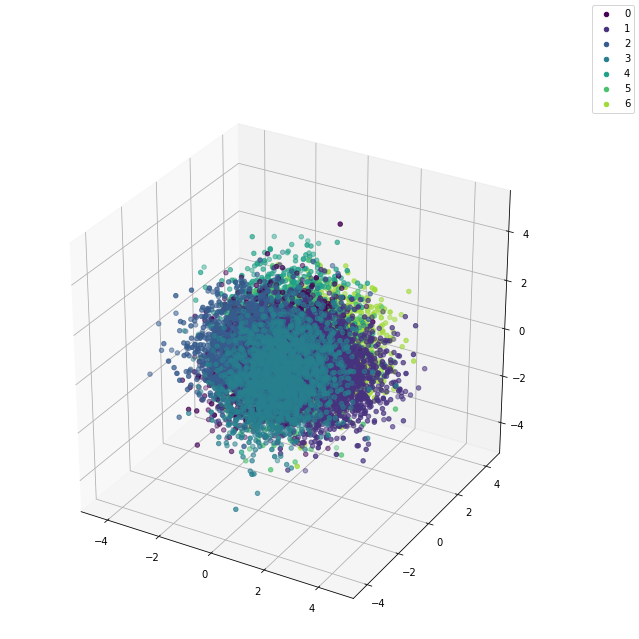

In [181]:
n_per_intent = 2000

latent = run['latent']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

## Embeddings

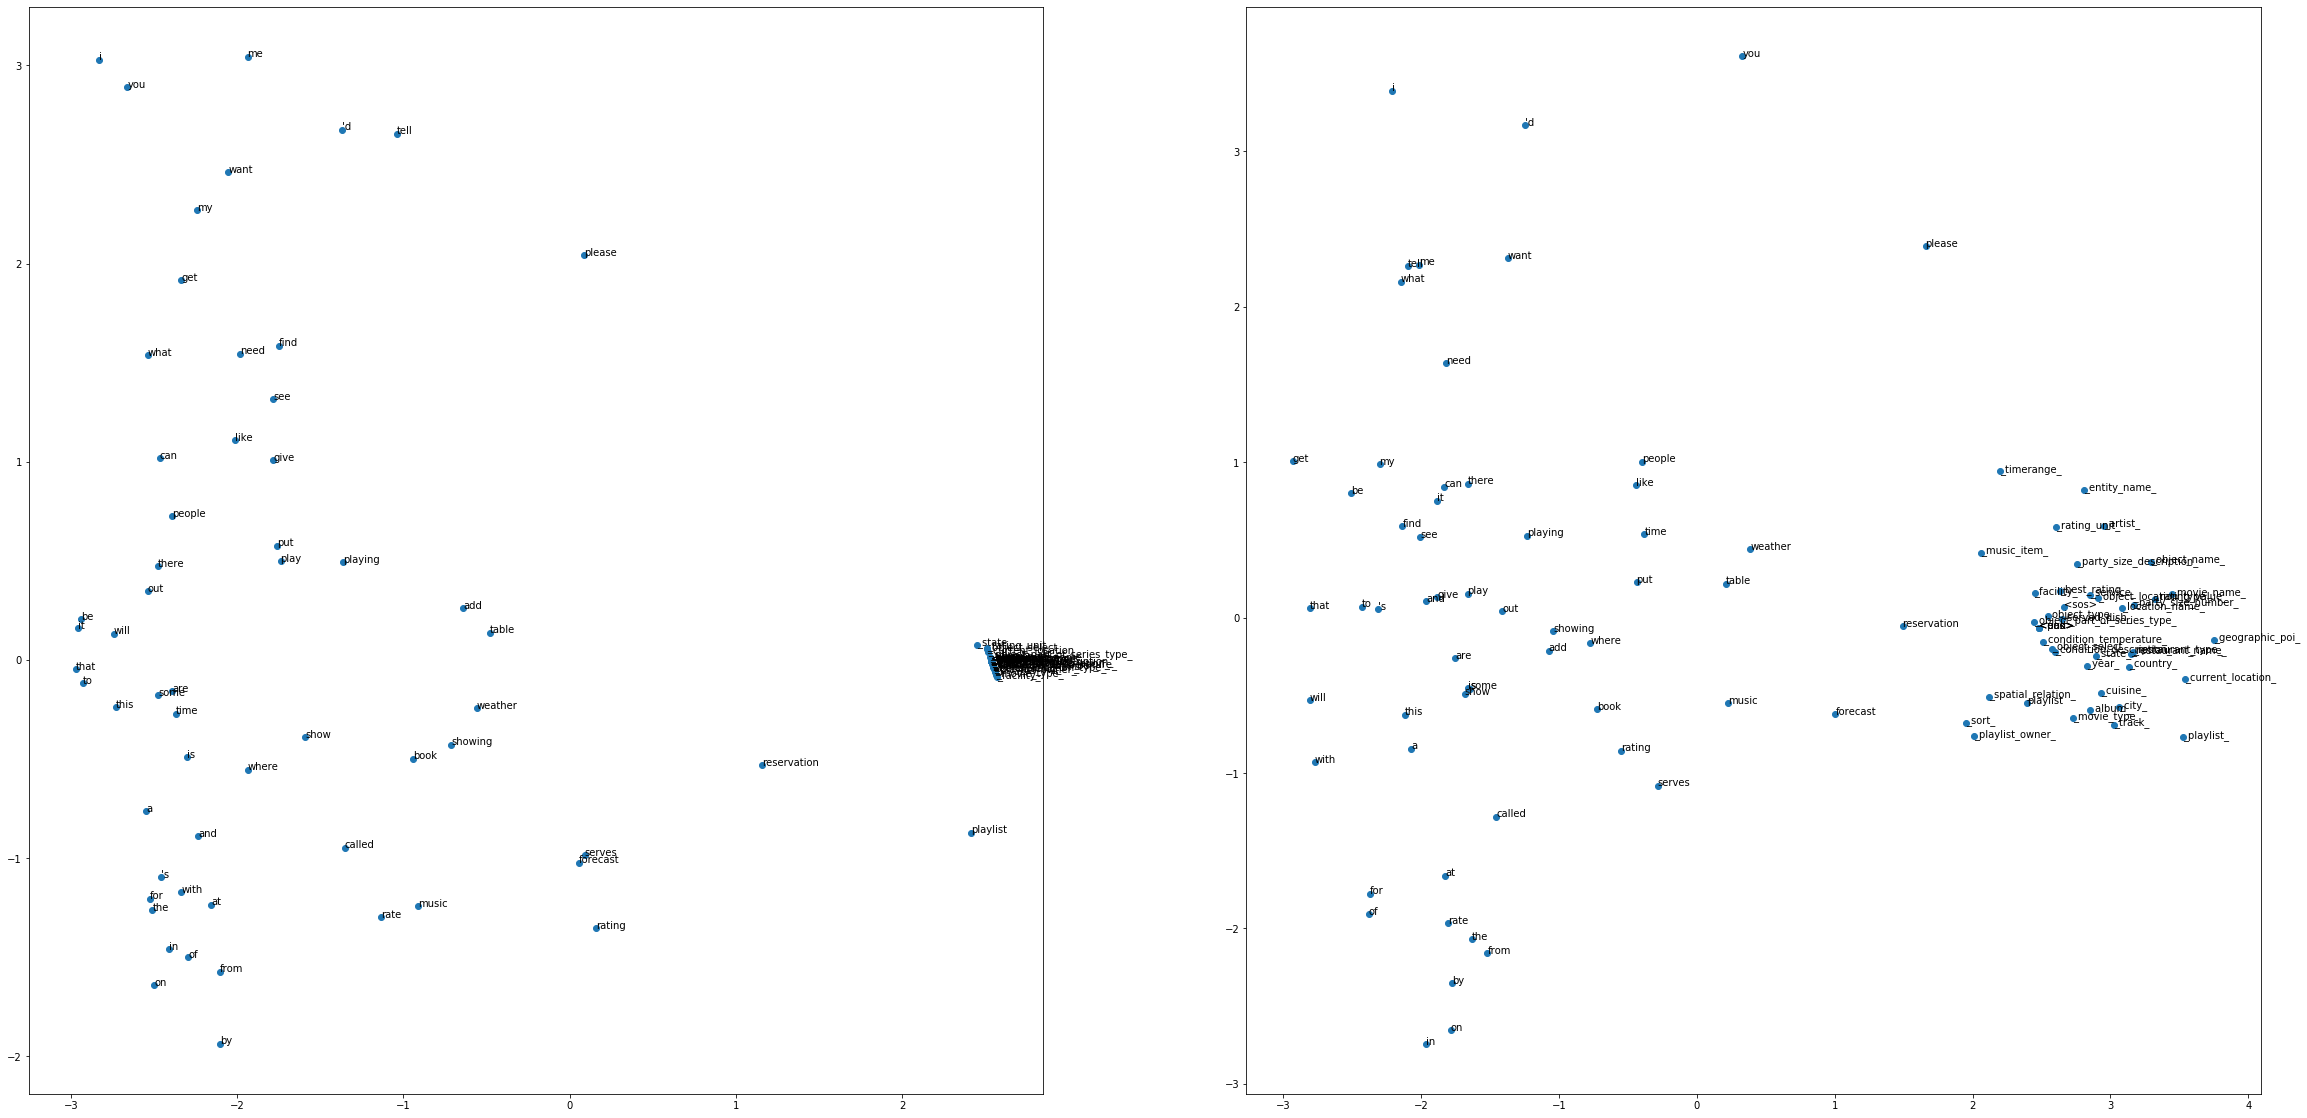

In [67]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(1, 2, figsize=(40,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors)
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]))

## Trajectories in latent space

In [209]:
!. ./venv/bin/activate

In [211]:
from models.embedding import Datasets
from models.cvae import CVAE
from utils.utils import to_device, interpolate, idx2word

run = torch.load('run.pkl')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature,
        conditional=False if args.conditional=='none' else True,
        bow=args.bow_loss
    )

state_dict = torch.load(args.pickle+'.pyT')
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

ModuleNotFoundError: No module named 'automatic_data_generation'

In [63]:
i2int

['GetWeather',
 'PlayMusic',
 'BookRestaurant',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork',
 'AddToPlaylist']

### Vary the continuous variable

In [202]:
for i, intent in enumerate(i2int):
    
    interp_dim = 1
    print(intent)

    #z1 = torch.randn([args.latent_size]).numpy()
    #z2 = torch.randn([args.latent_size]).numpy()
    z1 = torch.zeros([args.latent_size]).numpy()
    z2 = torch.zeros([args.latent_size]).numpy()
    z1[interp_dim] = -5
    z2[interp_dim] = +5
    z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
    batch_size=z.size(0)

    y_onehot = torch.zeros(batch_size, model.n_classes)
    y = torch.LongTensor(batch_size,1).fill_(i)
    y_onehot.scatter_(1, y, 1)
    samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

    print('-------INTERPOLATIONS-------')
    print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
    print('\n')

NameError: name 'i2int' is not defined

### Vary the discrete variable

z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

In [ ]:
import torch
import numpy as np
target = torch.arange(0,5*64).view(64,-1)
bow = torch.randn((64,500))

loss = 0
for b, t in zip(bow, target):
    loss += torch.sum(b[t])
print(loss)
x = bow[:,target].view(64,64,)
print(x.size())
print(torch.einsum('iik->',(x)))
    #print(np.sum([b[idx].numpy() for idx in t]))

# Grid search

In [266]:
root_dir = '/home/stephane/automatic-data-generation/automatic_data_generation'
results_dir = 'results_datasize_prop'
results_dir = 'results_gs_vsmall'

os.chdir(os.path.join(root_dir, results_dir))

In [267]:
runs = []

for filename in os.listdir('.'):
    if filename.endswith('.pkl'):
        runs.append(torch.load(filename))

In [268]:
data = {}
for arg_name in runs[0]['args'].__dict__.keys():
    data[arg_name] = [getattr(run['args'], arg_name) for run in runs]
data['bleu_quality'] = [run['metrics']['bleu_scores']['quality']['avg'] for run in runs]
data['bleu_diversity'] = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
data['bleu_diversity'] = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
data['accuracy'] = [run['metrics']['intent_accuracy'] for run in runs]
data['raw'] = [run['metrics']['improvement']['raw_acc'] for run in runs]
data['aug'] = [run['metrics']['improvement']['aug_acc'] for run in runs]

df = pd.DataFrame(data, columns=['datasize', 'epochs', 'x1', 'x2', 'k1', 'latent_size', 'learning_rate', 'bleu_quality', 'bleu_diversity', 'accuracy', 'raw', 'aug'])
df = df.sort_values(by = 'bleu_quality', ascending=False)
df

,datasize,epochs,x1,x2,k1,latent_size,learning_rate,bleu_quality,bleu_diversity,accuracy,raw,aug
7,500,10,300,100,0.0010,8,0.01,0.792434,0.204580,0.970,0.971429,0.958571
6,500,10,300,100,0.0001,32,0.01,0.776865,0.216199,0.976,0.970000,0.967143
2,500,10,300,100,0.0010,16,0.01,0.765951,0.193654,0.988,0.970000,0.968571
0,500,10,300,100,0.0001,16,0.01,0.764362,0.209857,0.974,0.968571,0.961429
1,500,10,300,100,0.0001,8,0.01,0.739159,0.193073,0.970,0.965714,0.962857
3,500,10,300,100,0.0001,16,0.10,0.052401,0.592601,0.142,0.970000,0.862857
5,500,10,300,100,0.0001,8,0.10,0.049216,0.461386,0.152,0.975714,0.874286
4,500,10,300,100,0.0001,32,0.10,0.026310,0.481555,0.144,0.978571,0.898571


In [270]:
irun = np.argmax(data['bleu_quality'])
list(zip(runs[irun]['generated']['intents'], runs[irun]['generated']['utterances']))[:20]

[('GetWeather', 'will it be chillier  in roseau  '),
 ('PlayMusic', 'play me the top-ten  symphony  by subliminal  '),
 ('PlayMusic', 'please play music from 2004  '),
 ('BookRestaurant', 'book a cafe  in delaware  for nine  people '),
 ('RateBook', 'rate victory for us is to see you suffer  a two  '),
 ('SearchScreeningEvent',
  'find the essay  for movies  at kerasotes theatres  '),
 ('PlayMusic', 'play music from 1993  '),
 ('BookRestaurant', 'book a cafe  in mt  for 9  people '),
 ('SearchScreeningEvent',
  "what 's the trailer  for films  at regal entertainment group  "),
 ('AddToPlaylist',
  "add this theme song  to laverne 's  animal stories  playlist "),
 ('RateBook', 'rate dreams of the raven  a three  '),
 ('RateBook', 'rate things fall apart  a 0  '),
 ('SearchCreativeWork', 'show me the schedule  rewind the film  '),
 ('AddToPlaylist',
  "please add this sound track  to jaime 's  nuclear blast novelties  playlist "),
 ('GetWeather',
  "what 's the weather going to be like i

No handles with labels found to put in legend.


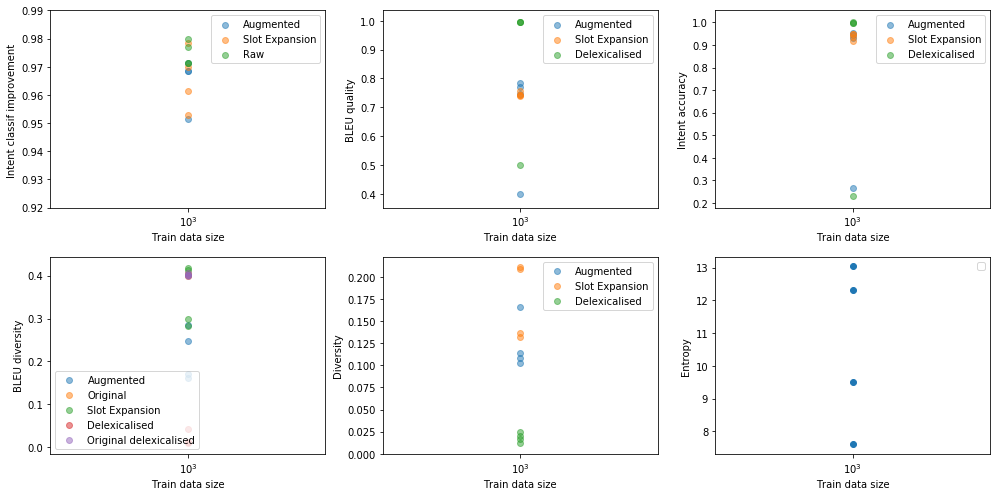

In [257]:
datasizes        = [run['args'].datasize for run in runs]
bleu_qualities   = [run['metrics']['bleu_scores']['quality']['avg'] for run in runs]
bleu_diversities = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
diversities      = [run['metrics']['diversity'] for run in runs]
entropies     = [run['metrics']['entropy'] for run in runs]
accuracies       = [run['metrics']['intent_accuracy'] for run in runs]
raw          = [run['metrics']['improvement']['raw_acc'] for run in runs]
augmented    = [run['metrics']['improvement']['aug_acc'] for run in runs]
se_augmented = [run['slot_expansion_metrics']['improvement']['aug_acc'] for run in runs]

delex_bleu_qualities   = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
delex_bleu_diversities = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_delex_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
delex_diversities      = [run['delexicalised_metrics']['diversity'] for run in runs]
delex_accuracies       = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]

se_bleu_qualities   = [run['slot_expansion_metrics']['bleu_scores']['quality']['avg'] for run in runs]
se_bleu_diversities = [run['slot_expansion_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
se_diversities      = [run['slot_expansion_metrics']['diversity'] for run in runs]
se_accuracies       = [run['slot_expansion_metrics']['intent_accuracy'] for run in runs]

fig, axarr = plt.subplots(2,3, figsize=(14,7))
axarr = axarr.flatten()

axarr[0].scatter(datasizes, augmented, label='Augmented'                ,alpha=0.5)
axarr[0].scatter(datasizes, se_augmented, label='Slot Expansion'        ,alpha=0.5)
axarr[0].scatter(datasizes, raw, label='Raw'                            ,alpha=0.5)
axarr[1].scatter(datasizes, bleu_qualities     ,label='Augmented'     ,alpha=0.5)
axarr[2].scatter(datasizes, accuracies         ,label='Augmented'     ,alpha=0.5)
axarr[3].scatter(datasizes, bleu_diversities   ,label='Augmented'     ,alpha=0.5)
axarr[3].scatter(datasizes, org_bleu_diversities,label='Original',alpha=0.5)
axarr[4].scatter(datasizes, diversities        ,label='Augmented'     ,alpha=0.5)
axarr[1].scatter(datasizes, se_bleu_qualities  ,label='Slot Expansion'  ,alpha=0.5)
axarr[2].scatter(datasizes, se_accuracies      ,label='Slot Expansion'  ,alpha=0.5)
axarr[3].scatter(datasizes, se_bleu_diversities,label='Slot Expansion'  ,alpha=0.5)
axarr[4].scatter(datasizes, se_diversities     ,label='Slot Expansion'  ,alpha=0.5)
axarr[1].scatter(datasizes, delex_bleu_qualities  ,label='Delexicalised',alpha=0.5)
axarr[2].scatter(datasizes, delex_accuracies      ,label='Delexicalised',alpha=0.5)
axarr[3].scatter(datasizes, delex_bleu_diversities,label='Delexicalised',alpha=0.5)
axarr[3].scatter(datasizes, org_delex_bleu_diversities,label='Original delexicalised',alpha=0.5)
axarr[4].scatter(datasizes, delex_diversities     ,label='Delexicalised',alpha=0.5)
axarr[5].scatter(datasizes, entropies                                   )

axarr[0].set_ylabel('Intent classif improvement ')
axarr[1].set_ylabel('BLEU quality')
axarr[2].set_ylabel('Intent accuracy')
axarr[3].set_ylabel('BLEU diversity')
axarr[4].set_ylabel('Diversity')
axarr[5].set_ylabel('Entropy')
for ax in axarr:
    ax.set_xscale('log')
    ax.set_xlabel('Train data size')
    ax.legend()
axarr[0].set_ylim(0.92,0.99)
fig.tight_layout()